## Working with PyTorch
More low-level look at GRNNs and some mechanisms

In [1]:
!pip install git+https://github.com/netbrainml/nbml.git
from nbml.pytorch import *
from IPython.display import clear_output
import torch.nn.functional as F
clear_output()

### LSTM
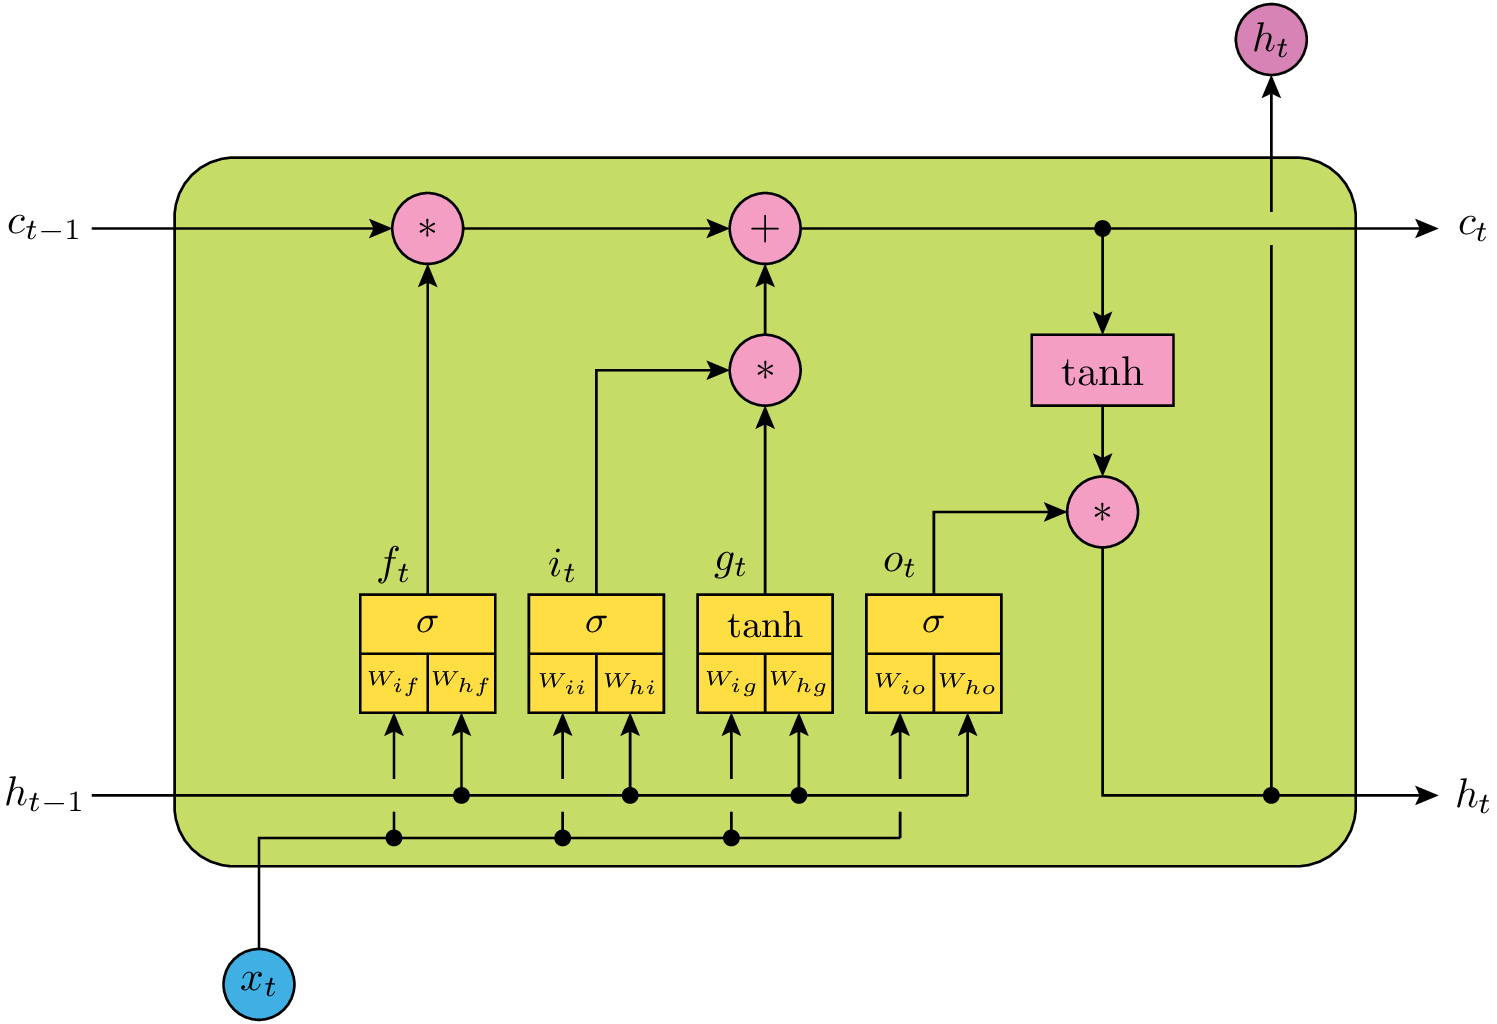

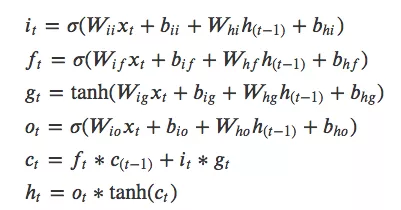

In [2]:
def linear(ni,nh): return nn.Sequential(nn.Linear(ni,nh, bias=True), nn.Linear(nh,nh, bias=True))

class LSTMCell(nn.Module):
    def __init__(self, ni, nh, bs):
        super().__init__()
        self.ii, self.ih = linear(ni,nh)
        self.fi, self.fh = linear(ni,nh)
        self.gi, self.gh = linear(ni,nh)
        self.oi, self.oh = linear(ni,nh)
        
        self.bs = bs ; self.nh = nh
        self.reset()
        
    def forward(self, x):
        i = torch.sigmoid(self.ii(x)+self.ih(self.h))
        f = torch.sigmoid(self.fi(x)+self.fh(self.h))
        g = torch.tanh(self.gi(x)+self.gh(self.h))
        o = torch.tanh(self.oi(x)+self.oh(self.h))
        self.c = f * self.c + i * g
        self.h = o * torch.tanh(self.c)
        return self.c, self.h
    
    def reset(self):
        self.h, self.c = torch.zeros(self.bs,self.nh), torch.zeros(self.bs,self.nh)

In [3]:
lstm = LSTMCell(1,16,1)
for item in range(3):
    print(lstm(torch.ones(1,1))[1])

tensor([[ 1.7769e-01,  8.0876e-02, -3.2198e-01,  9.0086e-02, -1.7208e-01,
         -2.4616e-01,  5.5643e-02, -2.8097e-02, -1.5550e-01,  1.5419e-01,
          1.7894e-01, -1.0430e-01,  1.0807e-01,  4.6625e-01,  2.0719e-01,
          2.7826e-05]], grad_fn=<MulBackward0>)
tensor([[ 0.2962,  0.0666, -0.4301,  0.1162, -0.2737, -0.3972,  0.0773, -0.0842,
         -0.2214,  0.2155,  0.2742, -0.2432,  0.1441,  0.6658,  0.2482, -0.0010]],
       grad_fn=<MulBackward0>)
tensor([[ 0.3787,  0.0416, -0.4672,  0.1227, -0.3237, -0.4702,  0.0864, -0.1068,
         -0.2570,  0.2312,  0.3196, -0.3123,  0.1432,  0.7343,  0.2458, -0.0022]],
       grad_fn=<MulBackward0>)


### GRU
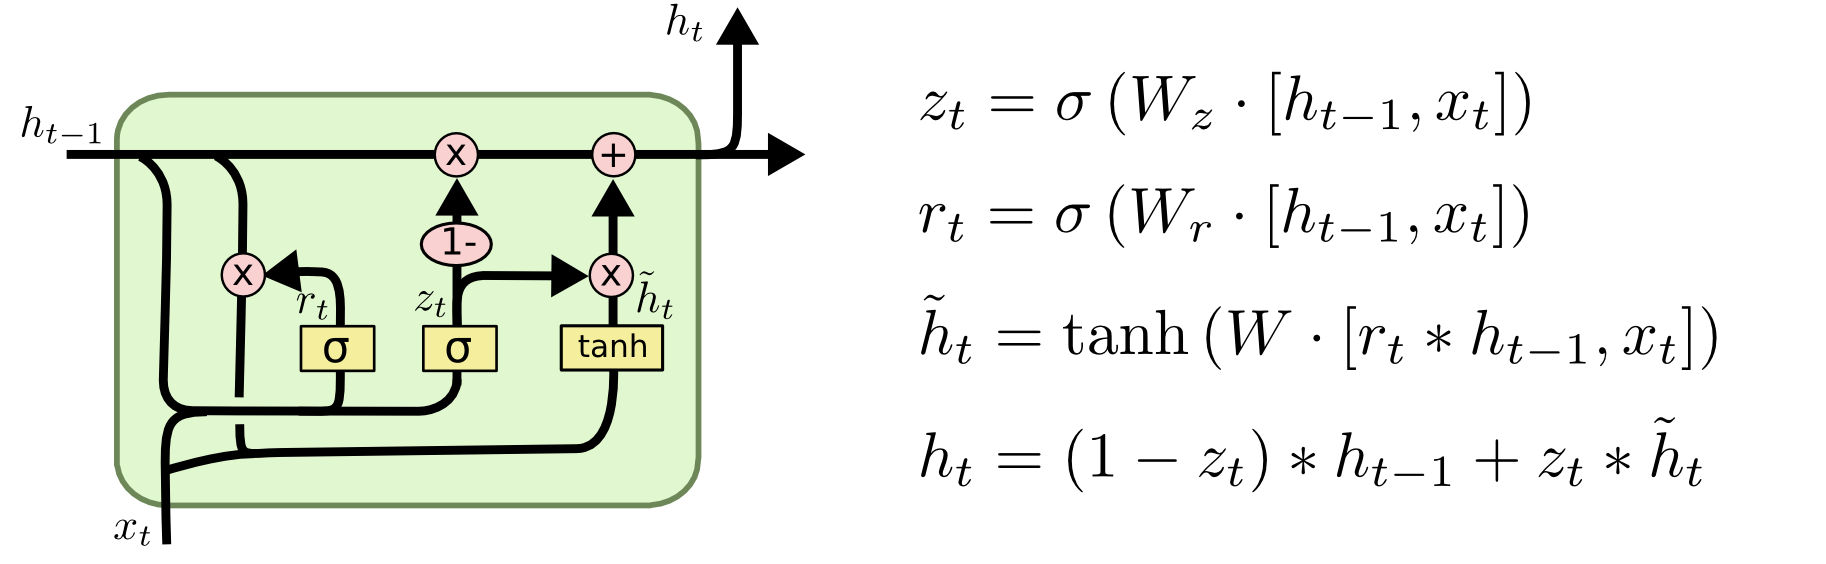

In [4]:
class GRUCell(nn.Module):
    def __init__(self, ni, nh, bs):
        super().__init__()
        self.zi, self.zh = linear(ni,nh)
        self.ri, self.rh = linear(ni,nh)
        self.hi, self.hh = linear(ni,nh)
        
        self.bs = bs ; self.nh = nh
        self.reset()
        
    def forward(self, x):
        z = torch.sigmoid(self.zi(x)+self.zh(self.h))
        r = torch.sigmoid(self.ri(x)+self.rh(self.h))
        hh = torch.tanh(self.hi(x)+self.hh(self.h*r))
        self.h = (1-z) * self.h + z * hh
        return self.h
    
    def reset(self):
        self.h = torch.zeros(self.bs,self.nh)

In [5]:
gru = GRUCell(1,16,1)
for item in range(3):
    print(gru(torch.ones(1,1)))

tensor([[ 0.3753, -0.0484,  0.0054,  0.1549, -0.4316, -0.2485, -0.1660,  0.0935,
          0.5783,  0.3523, -0.0239,  0.0833,  0.2029,  0.0195,  0.0926,  0.1304]],
       grad_fn=<AddBackward0>)
tensor([[ 0.4730, -0.0765, -0.0147,  0.2670, -0.6304, -0.4129, -0.2840,  0.1486,
          0.7498,  0.4066, -0.0256,  0.1630,  0.3387,  0.0241,  0.1580,  0.2199]],
       grad_fn=<AddBackward0>)
tensor([[ 0.5009, -0.0976, -0.0350,  0.3533, -0.7324, -0.5329, -0.3712,  0.1710,
          0.7960,  0.4144, -0.0213,  0.2332,  0.4136,  0.0222,  0.1971,  0.2758]],
       grad_fn=<AddBackward0>)


#### Multi-Layer RNNs
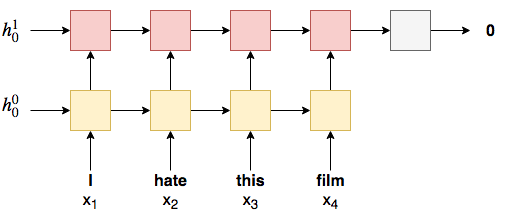

In [6]:
class MultiGRU(nn.Module):
    def __init__(self, ni, nh, bs, nl=1):
        super().__init__()
        self.gru = nn.Sequential(GRUCell(ni, nh, bs),
                                 *[GRUCell(nh, nh, bs) for _ in range(nl)])
        
    def forward(self, x):
        return self.gru(x)
    
    def reset(self):
        self.h = torch.zeros(self.bs,self.nh)

In [7]:
ml_gru = MultiGRU(1,16,1)
for item in range(3):
    print(ml_gru(torch.ones(1,1)))

tensor([[ 0.0849,  0.0491, -0.0182,  0.1728,  0.0312,  0.1332,  0.0240,  0.0964,
         -0.0584, -0.0879,  0.3952,  0.2308,  0.3934,  0.1370,  0.2017, -0.1854]],
       grad_fn=<AddBackward0>)
tensor([[ 0.0724,  0.1082, -0.0308,  0.3189,  0.0840,  0.2036,  0.0535,  0.1477,
         -0.1580, -0.1364,  0.5937,  0.3111,  0.5693,  0.1822,  0.3393, -0.2622]],
       grad_fn=<AddBackward0>)
tensor([[ 0.0298,  0.1591, -0.0354,  0.4202,  0.1146,  0.2466,  0.0722,  0.1778,
         -0.2456, -0.1762,  0.6945,  0.3264,  0.6396,  0.1993,  0.4207, -0.2803]],
       grad_fn=<AddBackward0>)


### Dropout
Randomly 'drop' nodes from forward and back propagation during training. For inference/validation, use all nodes discounted by a factor p.
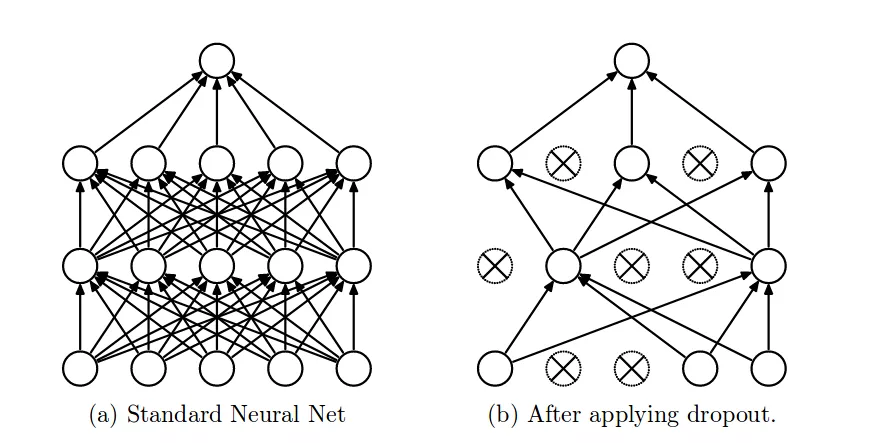

In [8]:
class MultiGRU_do(nn.Module):
    def __init__(self, ni, nh, bs, do=0.5, nl=2):
        super().__init__()
        self.gru = nn.Sequential(GRUCell(ni, nh, bs),
                                 *[nn.Sequential(GRUCell(nh, nh, bs),nn.Dropout(p=do)) for _ in range(nl)])
        
    def forward(self, x):
        return self.gru(x)
    
    def reset(self):
        self.h = torch.zeros(self.bs,self.nh)

In [9]:
ml_gru_do = MultiGRU_do(1,16,1)
for item in range(3):
    print(ml_gru_do(torch.ones(1,1)))

tensor([[-0.1015, -0.0000, -0.0000,  0.0460,  0.1830, -0.0000,  0.0000,  0.1974,
          0.0000, -0.2075, -0.0000,  0.0953,  0.0000, -0.0000, -0.1006,  0.0000]],
       grad_fn=<MulBackward0>)
tensor([[-0.3988, -0.2612, -0.4180,  0.0000,  0.0000, -0.0000,  0.0000,  0.0000,
          0.1639, -0.2178,  0.0000,  0.0000,  0.0000, -0.0000, -0.0000,  0.4093]],
       grad_fn=<MulBackward0>)
tensor([[-0.0000,  0.3059, -0.1548,  0.0000,  0.1362, -0.0000,  0.5653,  0.0000,
          0.0000, -0.3268,  0.0213,  0.0000,  0.0000,  0.0000, -0.4472,  0.5962]],
       grad_fn=<MulBackward0>)


### Bidirectional
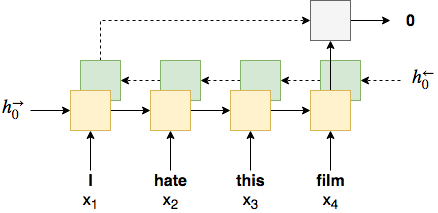

In [10]:
class MultiGRU_bd(nn.Module):
    def __init__(self, ni, nh, bs, nl=2):
        super().__init__()
        self.fgru = nn.Sequential(GRUCell(ni, nh, bs),
                                 *[nn.Sequential(GRUCell(nh, nh, bs)) for _ in range(nl)])
        self.bgru = nn.Sequential(GRUCell(ni, nh, bs),
                                 *[nn.Sequential(GRUCell(nh, nh, bs)) for _ in range(nl)])
        
    def forward(self, x, backward=False):
        return self.bgru(x) if backward else self.fgru(x)
    
    def reset(self):
        self.h = torch.zeros(self.bs,self.nh)

In [11]:
ml_gru_bd = MultiGRU_bd(1,16,1)
#Reading data normally
for item in range(3):
    fo = ml_gru_bd(torch.ones(1,1))

#Reading data in reverse
for item in range(3):
    bo = ml_gru_bd(torch.ones(1,1), backward=True)

fo + bo

tensor([[ 0.4321,  0.0736,  0.1088, -0.0156,  0.1517, -0.3530, -0.1064,  0.2030,
         -0.0333, -0.0926, -0.2642, -0.5155,  0.4134,  0.2715, -0.5306,  0.4881]],
       grad_fn=<AddBackward0>)